In [3]:
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
# az.style.use('arviz-white') 
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['legend.fontsize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['figure.titlesize']=15

#### 4M1.

In [9]:
with pm.Model() as m1:
    mu = pm.Normal('mu',  mu=0, sigma=10)
    sigma = pm.Exponential('sigma', lam=1)
    y = pm.Normal('y', mu=mu, sigma=sigma)
    prior_pred = pm.sample_prior_predictive(samples=500)

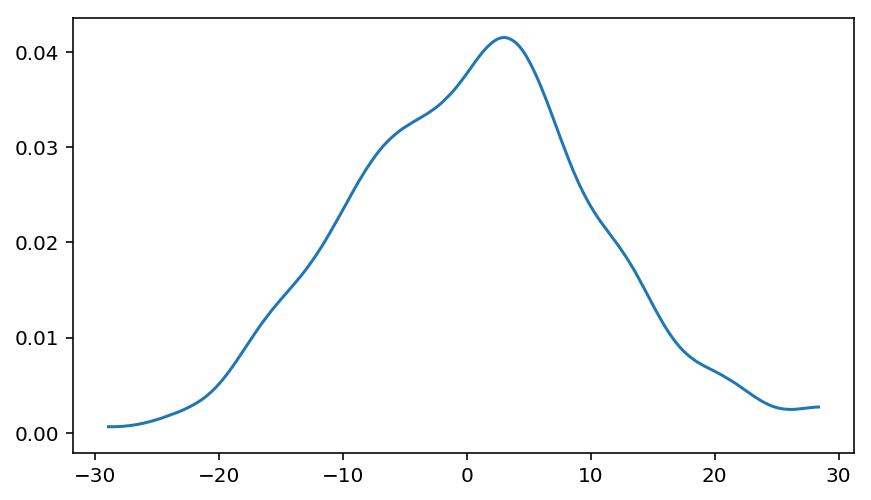

In [17]:
pm.kdeplot(prior_pred['y'])

#### 4M7

Some findings: 
- the performance of posterior prediction on height has not changed, based on rmse on trainset and posterior predictive plots on uncertainty. The HPD width of target variable (dependent variable) and that of mu has not changed. 
- The variance of a, as expected, has gone up. More interestingly, it is the covariance between a and b which has gone up too. 'b' now compensates the wider fluctuation in a and the cov of a & b maintains the posterior predictive performance. 

In [18]:
d = pd.read_csv("~/Learning_DS/pymc3_resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

In [23]:
# with centering the predictor
with pm.Model() as m7_v1:
    # data
    height = pm.Data('height', d2.height)
    weight = pm.Data('weight', d2.weight - d2.weight.mean())
    
    # prior
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # regression
    mu = a + b * weight
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)

    # sampling
    trace_7_v1 = pm.sample(1000, tune=1000)
    post_pred_samples_v1 = pm.sample_posterior_predictive(trace_7_v1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
100%|██████████| 4000/4000 [00:36<00:00, 109.87it/s]


In [24]:
# without centering the predictor
with pm.Model() as m7_v2:
    # data
    height = pm.Data('height', d2.height)
    weight = pm.Data('weight', d2.weight)
    
    # prior
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # regression
    mu = a + b * weight
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)

    # sampling
    trace_7_v2 = pm.sample(1000, tune=1000)
    post_pred_samples_v2 = pm.sample_posterior_predictive(trace_7_v2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
100%|██████████| 4000/4000 [00:35<00:00, 112.33it/s]


In [36]:
rmse_c = np.sqrt(mean_squared_error(d2.height, post_pred_samples_v1["height_hat"].mean(0)))
rmse_nc = np.sqrt(mean_squared_error(d2.height, post_pred_samples_v2["height_hat"].mean(0)))
print(f"RMSE of model which centers the predictor: {rmse_c:.2f}")
print(f"RMSE of model which does not center the predictor: {rmse_nc:.2f}")

RMSE of model which centers the predictor: 5.07
RMSE of model which does not center the predictor: 5.07


In [39]:
az.summary(trace_7_v1, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,154.599,0.277,154.165,155.048
b,0.903,0.043,0.834,0.971
sigma,5.105,0.199,4.804,5.433


In [40]:
az.summary(trace_7_v2, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
a,114.435,1.959,111.416,117.609
b,0.893,0.043,0.820,0.956
sigma,5.102,0.199,4.783,5.403


In [46]:
pm.trace_to_dataframe(trace_7_v1).cov()

,a,b,sigma
a,0.076688,-0.000296,-0.000454
b,-0.000296,0.001838,-0.000074
sigma,-0.000454,-0.000074,0.039584


In [47]:
pm.trace_to_dataframe(trace_7_v2).cov()

,a,b,sigma
a,3.838942,-0.083509,0.001179
b,-0.083509,0.001853,-0.000018
sigma,0.001179,-0.000018,0.039426


In [48]:
weight_seq = np.arange(25, 71)

In [54]:
with m7_v1:
    pm.set_data({"weight": weight_seq-d2.weight.mean()})
    height_ppc_v1 = pm.sample_posterior_predictive(trace_7_v1)

100%|██████████| 4000/4000 [00:39<00:00, 100.14it/s]


In [55]:
with m7_v2:
    pm.set_data({"weight": weight_seq})
    height_ppc_v2 = pm.sample_posterior_predictive(trace_7_v2)

100%|██████████| 4000/4000 [00:39<00:00, 100.31it/s]


In [64]:
mu_pred_v1 = (trace_7_v1["a"] + trace_7_v1["b"] * (weight_seq.reshape(-1, 1) - d2.weight.mean())).T
mu_pred_v2 = (trace_7_v2["a"] + trace_7_v2["b"] * weight_seq.reshape(-1, 1)).T

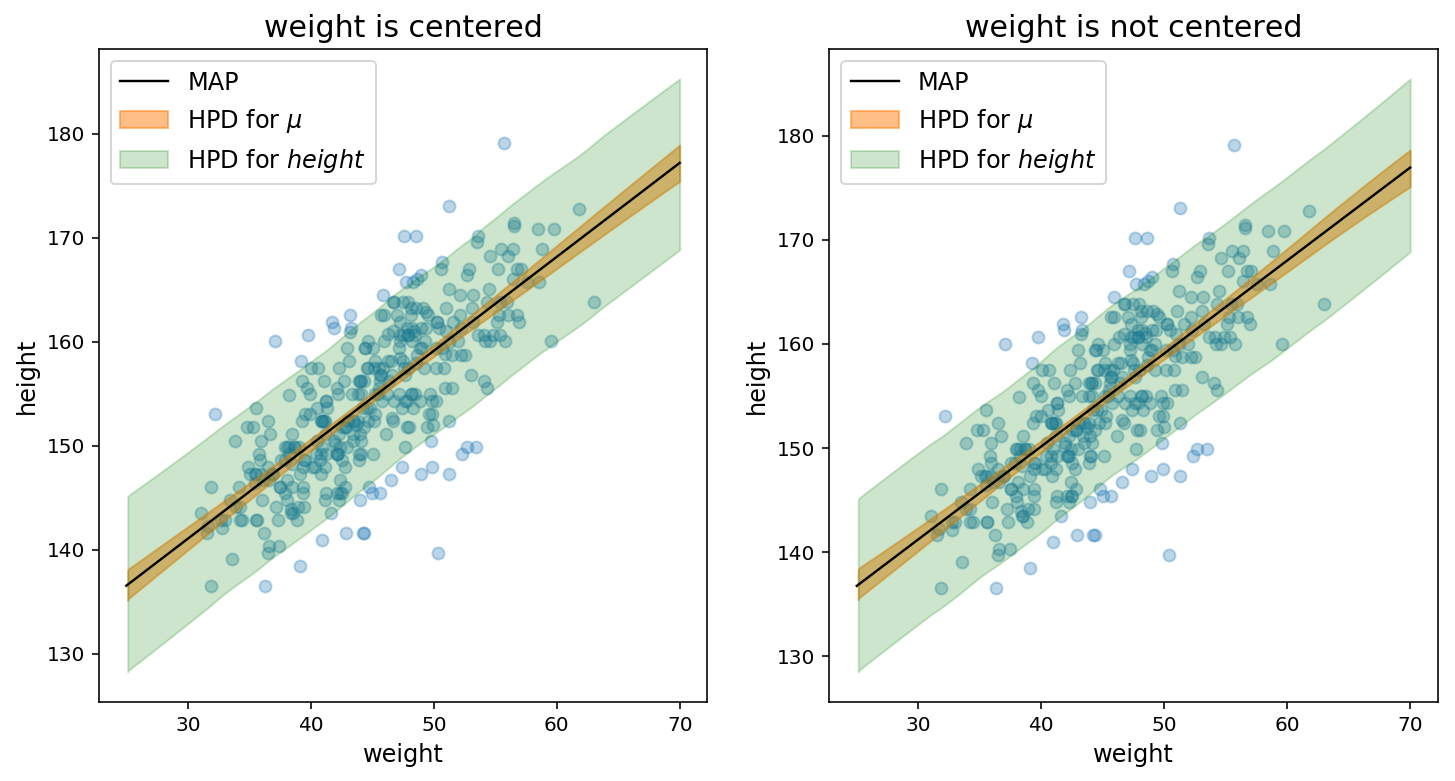

In [76]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.scatter(d2.weight, d2.height, alpha=0.3, label='')
ax1.plot(weight_seq, mu_pred_v1.mean(axis=0), 'k', linewidth=1.2, label='MAP')
az.plot_hpd(weight_seq, mu_pred_v1, color='C1', ax = ax1,
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(weight_seq, height_ppc_v1['height_hat'], color='g', ax = ax1,
           fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
ax1.set_xlabel('weight')
ax1.set_ylabel('height')
ax1.set_title("weight is centered", fontsize=15)
ax1.legend()

ax2.scatter(d2.weight, d2.height, alpha=0.3, label='')
ax2.plot(weight_seq, mu_pred_v2.mean(axis=0), 'k', linewidth=1.2, label='MAP')
az.plot_hpd(weight_seq, mu_pred_v2, color='C1', ax = ax2,
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(weight_seq, height_ppc_v2['height_hat'], color='g', ax = ax2,
           fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
ax2.set_xlabel('weight')
ax2.set_ylabel('height')
ax2.set_title("weight is not centered", fontsize=15)
ax2.legend()
pass